This Notebook has been created by PALISSON Antoine

In [26]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# RNN cells

In [27]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)

## One step at a time

**<font color='blue'>1.a. Create some time series using the `generate_time_series` function.<br> Set the batch_size parameter to 10 000 and the n_steps to 50<br>1.b. Look at the shape and display the some of these.**

In [28]:
series = generate_time_series(10000, 51)
series.shape

(10000, 51, 1)

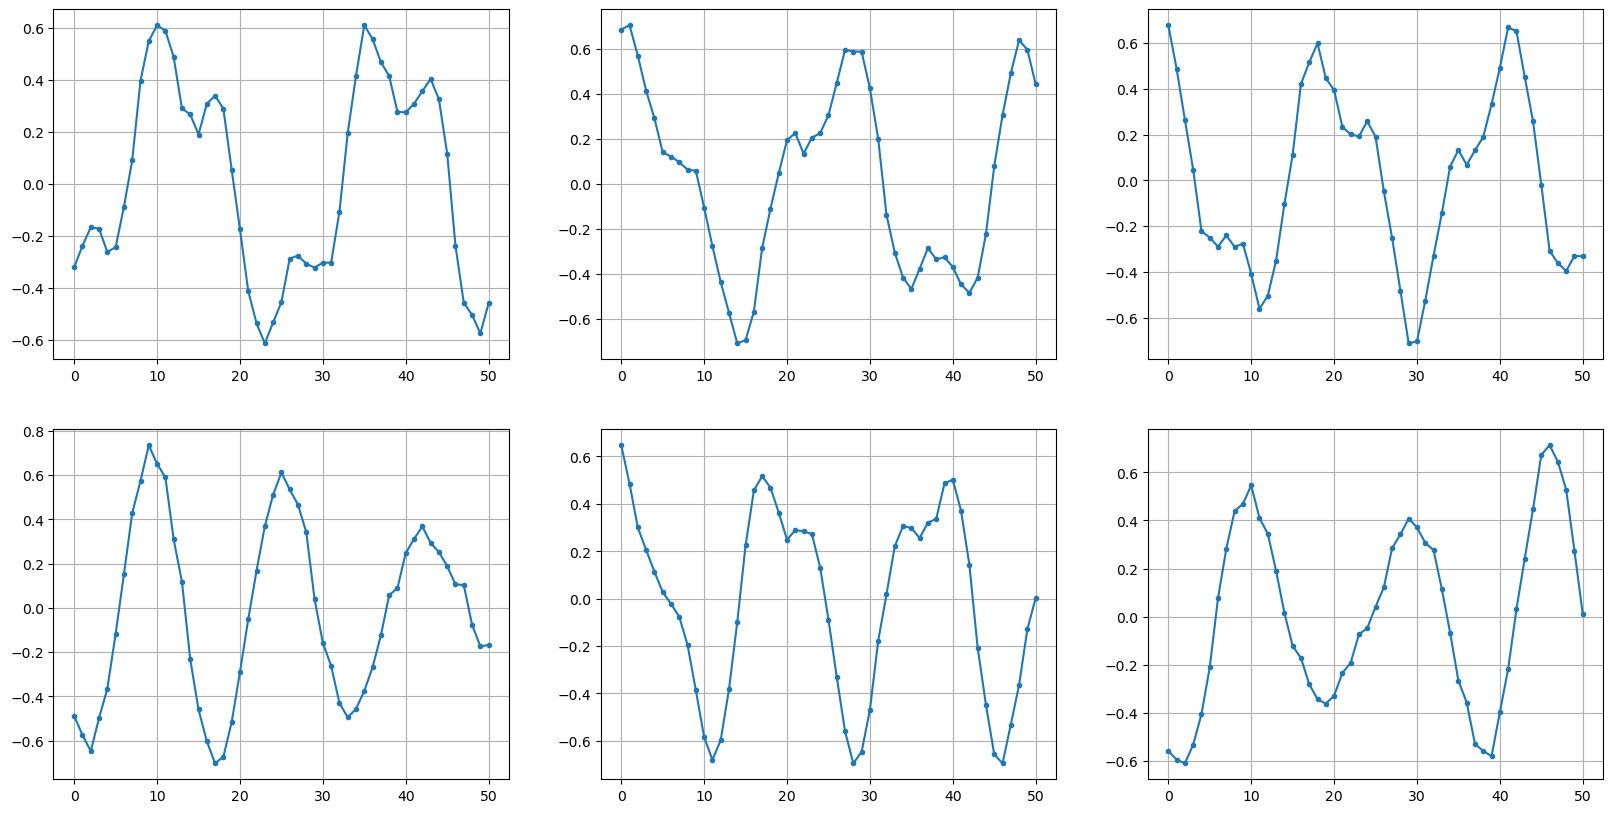

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(np.ravel(axs)):
    ax.plot(series[i, :], ".-")
    ax.grid()
plt.show()

**<font color='blue'>2.a. Create a train, a validation and a test set.<br>2.b. Separate the features (the first 50 values) from the label (the last value).**

In [30]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(series, test_size=0.2, shuffle=False)
train, val = train_test_split(train, test_size=0.2 / (1 - 0.2), shuffle=False)

In [31]:
X_train, y_train = train[:, :-1], train[:, -1]
X_val, y_val = val[:, :-1], val[:, -1]
X_test, y_yest = test[:, :-1], test[:, -1]

### Benchmark

In [32]:
def reset_seeds():
    os.environ['PYTHONHASHSEED'] = str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

To create a benchmark we will use the simplest neural network possible: one output layer with one neuron.

However, the data is of shape (...,51,1) which is not accepted by a regular MLP layer. We need to reshape the data to a (...,51) shape.

To do so you can use the `tf.keras.layers.Flatten()` layer from tensorflow keras.

**<font color='blue'>1. Create a neural network with a flattening layer followed by one Dense layer with no activation (the output).<br> Compile the network with an Adam optimizer with a learning rate of 0.005.**

*Tips: Don't forget to indicate the input shape in the first layer of the network.<br> Additionally, it might be useful to add an Early Stopping regularization to the network.*

In [34]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(50, 1)),
    tf.keras.layers.Dense(units=1),
])

model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              )
bench_history = model.fit(X_train, y_train,
                          batch_size=32,
                          epochs=40,
                          validation_data=(X_val, y_val),
                          callbacks=[early_stopping_cb])

Epoch 1/40
188/188 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0085
Epoch 2/40
188/188 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0058
Epoch 3/40
188/188 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 4/40
188/188 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 5/40
188/188 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/40
188/188 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 7/40
188/188 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/40
188/188 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 9/40
188/188 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 10/40
188/188 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0033

**<font color='blue'>2. Display the learning curves.**

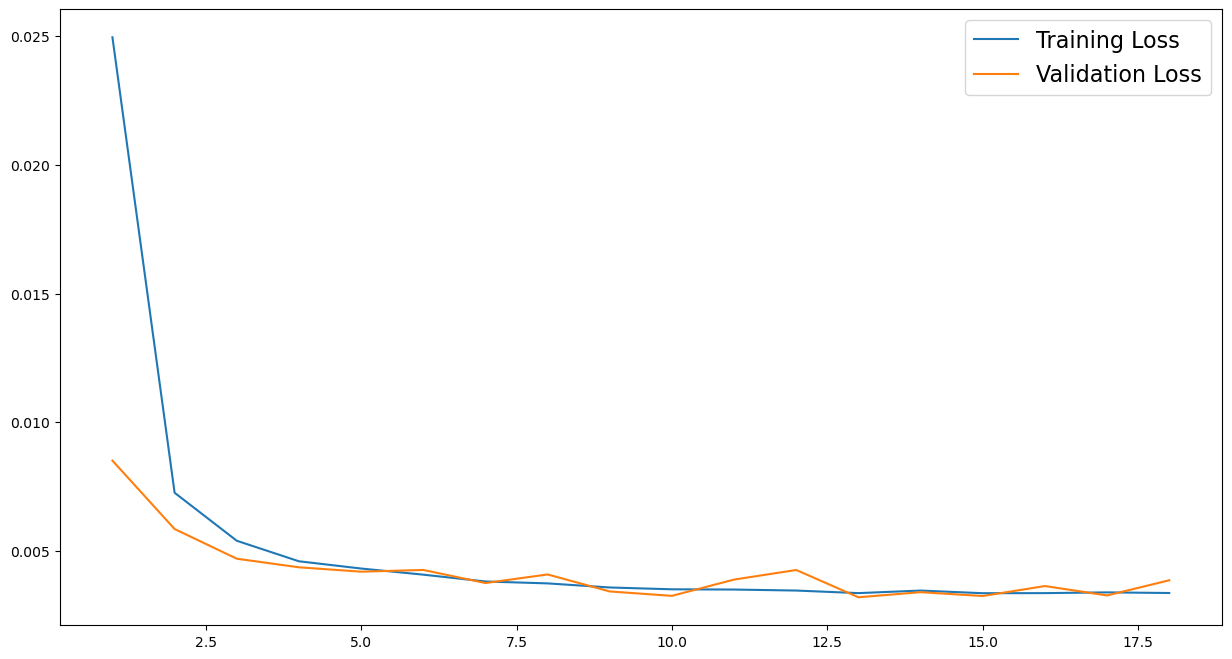

In [35]:
bench_loss = bench_history.history

plt.figure(figsize=(15, 8))

plt.plot(np.arange(1, early_stopping_cb.stopped_epoch + 2), bench_loss['loss'], label='Training Loss')
plt.plot(np.arange(1, early_stopping_cb.stopped_epoch + 2), bench_loss['val_loss'], label='Validation Loss')

plt.legend(fontsize=16)
plt.show()

**<font color='blue'>3.a. Predict the test set.<br>3.b. Display the prediction and the label on a graph.** 

**<font color='blue'>4. Compute the mean squared error.**

###Simple RNN

The [SimpleRNN class](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) in TensorFlow is used to create a simple recurrent neural network layer.

Here are some of the most important parameters:

* **units**: This parameter specifies the number neurons in the layer.

* **activation**: This parameter specifies the activation function to use for the output of the layer. The default value is "tanh", which is a common choice for RNNs.

* **use_bias**: This parameter determines whether to use a bias vector in the layer. The default value is True, which means that a bias vector will be used.

* **kernel_initializer**: This parameter specifies the method to use for initializing the weight matrix that connects the input to the hidden state. The default value is "glorot_uniform", which is a good choice for most cases.

* **recurrent_initializer**: This parameter specifies the method to use for initializing the weight matrix that connects the hidden state to itself. The default value is "orthogonal", which is a common choice for RNNs.

* **bias_initializer**: This parameter specifies the method to use for initializing the bias vector. The default value is "zeros", which initializes the bias vector to all zeros.

* **return_sequences**: This parameter determines whether to return the full sequence of outputs or just the output at the last timestep. The default value is False, which means that only the output at the last timestep will be returned.

* **return_state**: This parameter determines whether to return the final hidden state in addition to the output. The default value is False.

* **stateful**: This parameter determines whether the RNN should be stateful. If set to True, the RNN will retain its state across batches. The default value is False.

* **dropout**: This parameter specifies the dropout rate to use for the inputs and/or outputs of the RNN. The default value is 0, which means that no dropout will be applied.

**The SimpleRNN layer expects input data to be with shape (batch_size, timesteps)**. The reason for this is that SimpleRNN is a type of recurrent neural network that processes sequential data, such as time series or text data. The input data is typically a sequence of vectors, where each vector represents a timestep in the sequence.

*For example, if we have a dataset of text documents where each document is a sequence of words, we can represent each document as a matrix where each row corresponds to a word and each column corresponds to a feature of that word (such as its word embedding or one-hot encoding). We can then stack these matrices into a 3D tensor with shape (num_documents, num_timesteps, num_features), where num_timesteps is the maximum number of words in any document.*

**<font color='blue'>1.a. Create a neural network with a RNN layer that contains a single recurrent neuron and compile it.<br>1.b. Display the architecture and the parameters of the network.**

*Tips: Use the tf.keras.layers.SimpleRNN() with `units=1` ... don't forget the shape !*

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model = tf.keras.Sequential([tf.keras.layers.SimpleRNN(units=1)])

model.compile(loss=tf.keras.losses.MeanSquaredError,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              )
bench_history = model.fit(X_train, y_train,
                          batch_size=32,
                          epochs=40,
                          validation_data=(X_val, y_val),
                          callbacks=[early_stopping_cb])


**<font color='blue'>2.a. Train the neural network.<br>2.b. Display the learning curves.**

**<font color='blue'>3.a. Predict the test set.<br>3.b. Display the prediction and the label on a graph.** 

**<font color='blue'>4. Compute the mean squared error.<br>Is it better than the benchmark ?**

### Deep RNN

**When stacking multiple SimpleRNN layers on top of each other, it is common to set the `return_sequences` parameter of the lower layers to True** so that they return the full sequence of outputs rather than just the output at the last timestep. This is because the output of the lower layers needs to be fed into the upper layers in order to generate the final output, and each layer needs to have access to the full sequence of outputs in order to make the best prediction.

However, **the `return_sequences` parameter is typically set to False for the last SimpleRNN layer in a stacked RNN architecture** because the final output of the network is usually a single value or a fixed-length vector, rather than a sequence of values.

**<font color='blue'>1.a. Create a neural network with multiple RNN layers that contains multiple recurrent neurons and compile it.<br>1.b. Display the architecture and the parameters of the network.**

**<font color='blue'>2.a. Train the neural network.<br>2.b. Display the learning curves.**

**<font color='blue'>3.a. Predict the test set.<br>3.b. Display the prediction and the label on a graph.** 

**<font color='blue'>4. Compute the mean squared error.<br>Is it better than the benchmark & the Single RNN cell ?**

## Several steps at a time

**<font color='blue'>1. Create some time series using the `generate_time_series` function.<br> Set the batch_size parameter to 10 000 and the n_steps to 60.**

**<font color='blue'>2.a. Create a train, a validation and a test set.<br>2.b. Separate the features (the first 50 values) from the label (the last 10 values).**

**<font color='blue'>3. Display some of the features (first 50 values) and the label (last 10 values) with different colors.**

### Benchmark

**<font color='blue'>1. Create and train the same benchmark as in the previous part but with an output layer that contains 10 units.**

**<font color='blue'>2. Display the learning curves.**

**<font color='blue'>3.a. Predict the test set.<br>3.b. Display the prediction and the labels on a graph.** 

*Tips: Now, each prediction contains 10 values.*

**<font color='blue'>4. Compute the mean squared error.**

### Deep RNN

**<font color='blue'>1.a. Create a neural network with multiple RNN layers that contains multiple recurrent neurons and compile it.<br>1.b. Train it and display the learning curves.**

**<font color='blue'>2.a. Predict the test set.<br>2.b. Display the prediction and the label on a graph.** 

**<font color='blue'>3. Compute the mean squared error.<br>Is it better than the benchmark ?**

### Bidirectional Deep RNN

**The** [Bidirectional layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) **in TensorFlow is a wrapper layer that can be used to apply a recurrent neural network to a sequence of data in both forward and backward directions.** This allows the model to capture both past and future context when processing the sequence, which can improve its ability to model complex patterns in the data.

The Bidirectional layer in TensorFlow takes an recurrent layer as input, and creates two copies of the layer: one that processes the input sequence in forward order, and one that processes the input sequence in backward order. The outputs from each layer are then concatenated along the time axis to produce a single output sequence.

All you need to do is to wrap any recurrent layer inside of the `tf.keras.layers.Bidirectional()` layer:


```
tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(...))
```



**<font color='blue'>1.a. Create a deep recurrent neural network with bidirectional layers.<br>1.b. Train it and display the learning curves.**

**<font color='blue'>2.a. Predict the test set.<br>2.b. Display the prediction and the label on a graph.** 

**<font color='blue'>3. Compute the mean squared error.<br>Is it better than the Deep RNN ?**

# LSTM & GRU

**<font color='blue'>1.a. Load the AmazonReviews_Light dataset.<br>1.b. Keep only around 10% of the dataset.**

**In natural language processing (NLP), text data is typically represented as a sequence of words or subwords, rather than as raw text.** This sequence of words is often referred to as a **"tokenized" representation** of the text.

There are several ways to tokenize text data, including the **word-level tokenization which involves splitting the text into individual words**, where each word becomes a separate token. This is the most common type of tokenization and is used in many NLP tasks, such as sentiment analysis and text classification.

In the following exercise, we will use the word-level tokenization method.

The [TextVectorization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) is used to preprocess text data for use in a deep learning model. It takes in a batch of text strings and outputs a tensor of integer values, where each integer represents a token in the text. The TextVectorization layer can be customized in several ways, including by specifying the maximum vocabulary size, the output mode ('int' or 'binary'), the tokenization mode ('word' or 'character') and so on.

In order to use the TextVectorization layer:


1.   Create an instance of the TextVectorization layer : `vectorizer = TextVectorization(...)`
2.   Fit the vectorizer to the corpus of text data : `vectorizer.adapt(list of texts)`
3.   Use the vectorizer : `tokens = vectorizer(text)`

It has many parameters, here is an explanation for three of them:
* **max_tokens**: This parameter specifies the maximum number of tokens in the vocabulary. Any tokens that appear less frequently than this threshold will be treated as out-of-vocabulary (OOV) tokens and replaced with a special < OOV > token. This parameter is used in conjunction with the adapt method of the TextVectorization layer to automatically generate a vocabulary from the input text data.

* **output_mode**: This parameter specifies the output format of the TextVectorization layer. The two possible values are 'int' and 'binary'. If set to 'int', the layer will output integer values corresponding to the tokens in the vocabulary. If set to 'binary', the layer will output a binary vector representing the presence or absence of each token in the input text.

* **output_sequence_length**: This parameter specifies the length of the output sequence produced by the TextVectorization layer. If set to None, the output sequence will have variable length depending on the length of the input text. If set to a specific integer value, the output sequence will be truncated or padded to that length. This parameter is useful for ensuring that the input data has a fixed length, which is often necessary when working with neural networks.

**<font color='blue'>2.a. Create the TextVectorization layer with `max_tokens=5000`, `output_mode='int'` and `output_sequence_length=200`.<br>2.b. Use `.adapt()` method of the TextVectorization layer to get the vocabulary of the dataset.**

**<font color='blue'>3.a. Transform the text into tokens.<br>3.b. Separate the reviews from the label.<br>3.c. Split the data into a training, a validation and a testing sets.**

After tokenizing the input text data, the resulting sequence of integer tokens can be fed into a neural network for further processing and especially, to an embedding layer that will embed the tokens.

In natural language processing (NLP), an embedding is a way of representing words or phrases as vectors of numerical values. The goal of an embedding is to capture the underlying meaning or semantics of the words, so that words with similar meanings are represented by similar vectors in the embedding space.

There are several methods for generating embeddings in NLP, but one of the most commonly used methods is the Word2Vec algorithm. Word2Vec is a neural network-based algorithm that takes a large corpus of text as input and outputs a vector representation for each word in the vocabulary. The vectors are trained to capture the semantic relationships between the words, so that words with similar meanings are represented by similar vectors in the embedding space.

We can add an embedding to the model thanks to the Tensorflow [Embedding class](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).<br> It has several parameters that can be customized, including:

* **input_dim**: This parameter specifies the size of the vocabulary, i.e. the maximum integer value that can appear in the input sequence.

* **output_dim**: This parameter specifies the dimensionality of the dense embedding vectors.

* **input_length**: This parameter specifies the length of the input sequence.

In the following exercise, we will use the [LSTM layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). It has the very similar hyperparameters. 

**<font color='blue'>4.a. Create a model with an Embedding layer, with `input_dim=5000`,  `output_dim=20` and `mask_zero=True`, followed by two LSTM layers and an output layer for binary classification.<br>4.b. Display the architechture of the model and its number of parameters**

**<font color='blue'>5.a. Train the model.<br>5.b. Display the learning curves.**

*Tips : Don't forget about the shape for RNNs.*

The [GRU layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) use is very similar to the Simple RNN and LSTM.

**<font color='blue'>6.a. Do the same for the GRU layer.<br>6.b. Compare with the LSTM.<br> Which one gives the best accuracy ? Which one is the fastest ?**